## CPU vs GPU Cross Correlation Benchmark

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as pn
import tqdm
from flowdec import data as fd_data
from cytokit.ops import drift_compensation
from skimage.feature import register_translation
from skimage.transform import rescale
from scipy.ndimage.interpolation import shift
from skimage.exposure import rescale_intensity

In [2]:
acq = fd_data.bead_25pct()

In [3]:
img = acq.data
img = rescale_intensity(img, out_range='uint8').astype(np.uint8)
img.dtype, img.shape

(dtype('uint8'), (64, 64, 64))

In [4]:
img_shift = shift(img, (-5, 10, 15))
img_shift.dtype, img_shift.shape

(dtype('uint8'), (64, 64, 64))

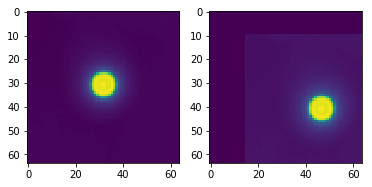

In [5]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img.max(axis=0))
axs[1].imshow(img_shift.max(axis=0))

In [6]:
def register_translation_noerr(src_image, target_image, upsample_factor=1, space="real"):
    """
    Lift from https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/register_translation.py#L140
    
    This removes anything related to error calculations so that this version is directly comparable to the 
    TensorFlow version
    """
    # images must be the same shape
    if src_image.shape != target_image.shape:
        raise ValueError("Error: images must be same size for "
                         "register_translation")

    # only 2D data makes sense right now
    if src_image.ndim != 2 and upsample_factor > 1:
        raise NotImplementedError("Error: register_translation only supports "
                                  "subpixel registration for 2D images")

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_image = np.array(src_image, dtype=np.complex128, copy=False)
        target_image = np.array(target_image, dtype=np.complex128, copy=False)
        src_freq = np.fft.fftn(src_image)
        target_freq = np.fft.fftn(target_image)
    else:
        raise ValueError("Error: register_translation only knows the \"real\" "
                         "and \"fourier\" values for the ``space`` argument.")

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifftn(image_product)

    # Locate maximum
    maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)),
                              cross_correlation.shape)
    midpoints = np.array([np.fix(axis_size / 2) for axis_size in shape])

    shifts = np.array(maxima, dtype=np.float64)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]
    return shifts

In [7]:
from timeit import default_timer as timer

def run(op):
    start = timer()
    op()
    end = timer()
    return end - start

def rescale_image(img, scale_factor):
    return rescale(
        img, scale_factor, anti_aliasing=False, 
        mode='constant', multichannel=False, preserve_range=True
    ).astype(np.uint8)

def benchmark(img, img_shift):
    op = drift_compensation.TranslationCalculator(3)
    op.initialize()
    
    df = []
    for scale_factor in tqdm.tqdm(np.arange(1., 5., .2)):
        img_rs = rescale_image(img, scale_factor)
        img_shift_rs = rescale_image(img_shift, scale_factor)
        
        df.append({
            'scale_factor': scale_factor,
            'size': img_rs.size,
            'shape': img_rs.shape,
            'cpu': run(lambda: register_translation_noerr(img_rs, img_shift_rs)),
            'gpu': run(lambda: op.run(img_rs, img_shift_rs))
        })
    return pd.DataFrame(df)


In [ ]:
%%time
df = []
for i in tqdm.tqdm(range(5)):
    df.append(benchmark(img, img_shift).assign(iteration=i))
df = pd.concat(df)

 95%|█████████▌| 19/20 [03:35<00:25, 25.81s/it]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 19
Data columns (total 6 columns):
cpu             100 non-null float64
gpu             100 non-null float64
scale_factor    100 non-null float64
shape           100 non-null object
size            100 non-null int64
iteration       100 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 5.5+ KB


In [24]:
df.iteration.value_counts()

4    20
3    20
2    20
1    20
0    20
Name: iteration, dtype: int64

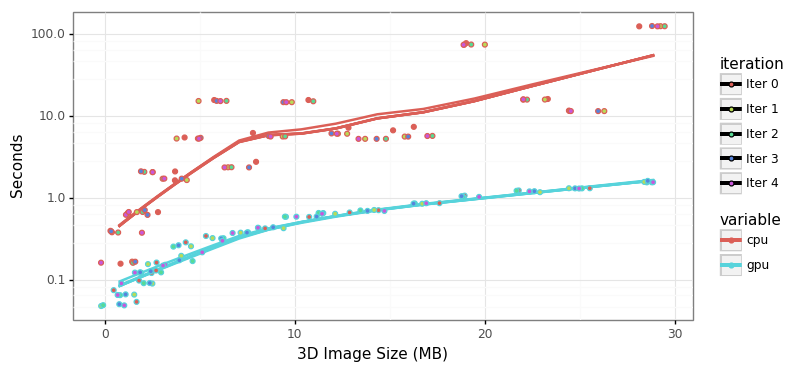

<ggplot: (-9223363292298658486)>

In [45]:
(
    pn.ggplot(
        df.query('scale_factor > 1.2')\
            .assign(iteration=lambda df: 'Iter ' + df['iteration'].astype(str))\
            .assign(mb=lambda df: df['size']/1000000)[['mb', 'iteration', 'cpu', 'gpu']]\
            .melt(id_vars=['mb', 'iteration']), 
        pn.aes(x='mb', y='value', color='variable', fill='iteration')
    ) +
    pn.stat_smooth(se=False) +
    pn.geom_jitter(width=1) +
    pn.scale_y_log10() + 
    pn.theme_bw() +
    pn.xlab('3D Image Size (MB)') +
    pn.ylab('Seconds') +
    pn.theme(figure_size=(8, 4))
)

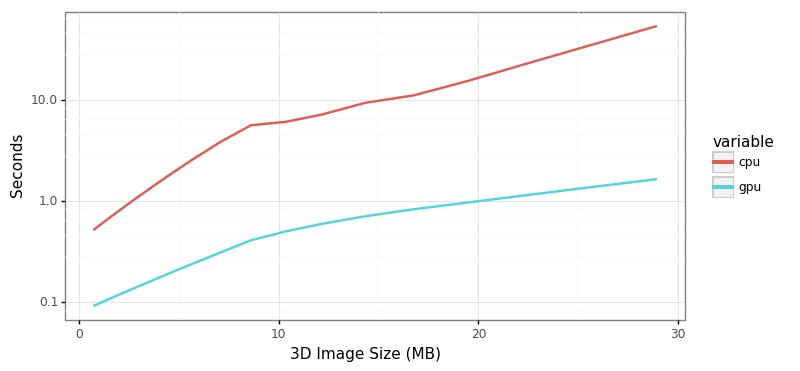

<ggplot: (8744555794429)>

In [43]:
# Smooth across all replicates
(
    pn.ggplot(
        df.query('scale_factor > 1.2')\
            .assign(iteration=lambda df: 'Iter ' + df['iteration'].astype(str))\
            .assign(mb=lambda df: df['size']/1000000)[['mb', 'iteration', 'cpu', 'gpu']]\
            .melt(id_vars=['mb', 'iteration']), 
        pn.aes(x='mb', y='value', color='variable')
    ) +
    pn.stat_smooth(se=False) +
    pn.scale_y_log10() + 
    pn.theme_bw() +
    pn.xlab('3D Image Size (MB)') +
    pn.ylab('Seconds') +
    pn.theme(figure_size=(8, 4))
)